In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

In [3]:
# Function to fetch stock data using yfinance
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    # return (stock_data['Close'].pct_change().dropna() + 1).cumprod() - 1
    return stock_data['Close']

# Define the fixed stock and a list of different stocks to pair with
fixed_stock = '1876.HK'
stocks_to_pair = [
    '0291.HK', 
    '0168.HK',  
    # '9633.HK', 
    # '2460.HK'
]  # Add more stocks as needed
name_mapping = {
    '1876.HK': 'Budweiser APAC',
    '0291.HK': 'CR Beer',
    '0168.HK': 'Qing Dao Beer',
    # '9633.HK': 'Nong Fu Shan Quan',
    # '2460.HK': 'CR Drinks'
}

[*********************100%***********************]  3 of 3 completed


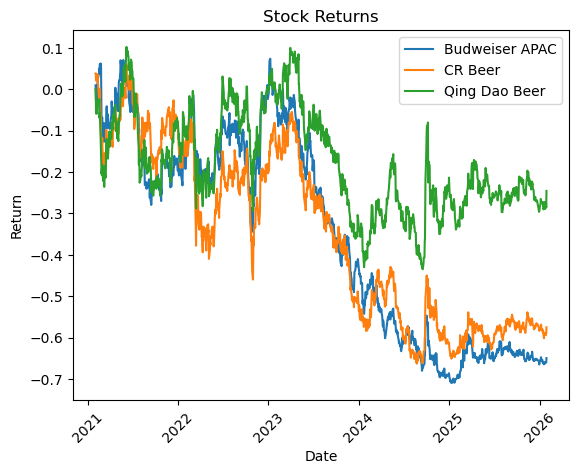

In [4]:
# Fetch historical stock price data and perform analysis for each pair
results = []
start_date = "2021-02-01"
end_date = "2026-01-30"
price_data = fetch_stock_data([fixed_stock]+stocks_to_pair, start_date, end_date)
price_data = price_data.fillna(method='ffill').dropna()
returns = (price_data.pct_change().dropna() + 1).cumprod() - 1
fixed_stock_data = returns[fixed_stock]
plt.plot(fixed_stock_data, label=name_mapping[fixed_stock])
for stock in stocks_to_pair:
    paired_stock_data = returns[stock]

    # cointegration_test = coint(fixed_stock_data, paired_stock_data)
    # cointegration_p_value = cointegration_test[1]

    # Step 1: Regression of paired stock on fixed stock
    X = sm.add_constant(fixed_stock_data)
    model = sm.OLS(paired_stock_data, X).fit()
    residuals = model.resid

    # Step 2: Test residuals for stationarity
    adf_test = sm.tsa.adfuller(residuals)
    adf_p_value = adf_test[1]

    correlation = fixed_stock_data.corr(paired_stock_data)

    results.append({
        'Fixed Stock': name_mapping[fixed_stock],
        'Paired Stock': name_mapping[stock],
        'Cointegration p-value': adf_p_value,
        'Correlation': correlation,
    })

    plt.plot(paired_stock_data, label=name_mapping[stock])

# Create a DataFrame to present the results
results_df = pd.DataFrame(results)

plt.title('Stock Returns')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Return')
plt.legend()
plt.show()

In [5]:
results_df

,Fixed Stock,Paired Stock,Cointegration p-value,Correlation
0,Budweiser APAC,CR Beer,0.007521,0.950845
1,Budweiser APAC,Qing Dao Beer,0.000544,0.819736


In [6]:
stock1_data = price_data[fixed_stock]
stock2_data = price_data["0291.HK"]
stock1_lot = 100
stock2_lot = 500

In [7]:
# Scale the data based on shares per hand
stock1_data *= stock1_lot
stock2_data *= stock2_lot

# Calculate the spread between the two stocks
spread = stock1_data - stock2_data

# Perform Augmented Dickey-Fuller (ADF) test to analyze mean-reverting tendencies
adf_test = adfuller(spread.dropna(), maxlag=1)
adf_statistic = adf_test[0]
adf_p_value = adf_test[1]

# Display ADF test results
print("ADF Statistic:", adf_statistic)
print("ADF p-value:", adf_p_value)

ADF Statistic: -1.8366739911024883
ADF p-value: 0.3624120037734419


In [8]:
# Risk params: leverage and maintenance margin for margin call
leverage = 2.0
maintenance_margin_pct = 0.3

# Define entry and exit thresholds
entry_threshold = 1.5
exit_threshold = 0.3
stop_loss_pct = 0.02 * leverage

# Define initial capital
initial_capital = 100000

Stop loss triggered at index 84, date 2021-06-07 00:00:00, trade P/L: -7260.03, current capital: 94759.62
Stop loss triggered at index 93, date 2021-06-21 00:00:00, trade P/L: -4990.01, current capital: 89627.80
Stop loss triggered at index 214, date 2021-12-14 00:00:00, trade P/L: -5656.43, current capital: 107525.68
Stop loss triggered at index 232, date 2022-01-10 00:00:00, trade P/L: -4840.57, current capital: 102502.81
Stop loss triggered at index 429, date 2022-10-28 00:00:00, trade P/L: -10383.52, current capital: 114233.50
Stop loss triggered at index 578, date 2023-06-09 00:00:00, trade P/L: -5447.04, current capital: 130359.63
Stop loss triggered at index 672, date 2023-10-27 00:00:00, trade P/L: -6652.16, current capital: 151290.37
Stop loss triggered at index 688, date 2023-11-20 00:00:00, trade P/L: -6758.09, current capital: 144195.11
Stop loss triggered at index 708, date 2023-12-18 00:00:00, trade P/L: -6910.33, current capital: 137001.89
Stop loss triggered at index 83

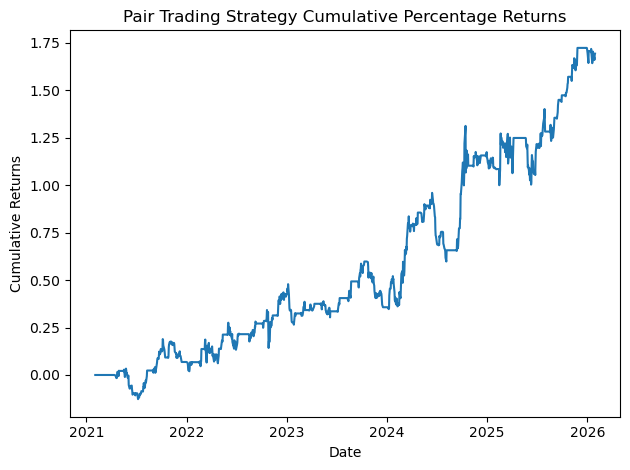

In [ ]:
# Calculate the price ratio between the two stocks
price_ratio = stock1_data / stock2_data

# Calculate z-score of the spread based on a rolling 3-month window
spread_mean = spread.rolling(window=30).mean()
spread_std = spread.rolling(window=30).std()
z_score = (spread - spread_mean) / spread_std

current_capital = initial_capital

# Generate signals
signals = np.where(z_score > entry_threshold, -1, np.where(z_score < -entry_threshold, 1, 0))

# Backtest the pair trading strategy
position = 0
pr = price_ratio.iloc[0]
pct_returns = []
completed_trades = 0
margin_call_count = 0
t = 0
a , b = 0, 0
current_trade_pl = 0
multiple = 0

for i in range(1, len(signals)):
    cost = 0
    old_position = position

    # Compute daily realized P/L based on previous position
    if old_position == 1:
        r = multiple *(a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]) - b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]))
    elif old_position == -1:
        r = multiple * (b * (stock2_data.iloc[i] - stock2_data.iloc[i-1]) - a * (stock1_data.iloc[i] - stock1_data.iloc[i-1]))
    else:
        r = 0

    # Entry signals
    if signals[i] == 1 and position == 0:
        position = 1
        pr = price_ratio.iloc[i]

    elif signals[i] == -1 and position == 0:
        position = -1
        pr = price_ratio.iloc[i]

    # Exit / stop loss
    elif current_trade_pl / current_capital <= -stop_loss_pct or (signals[i] == 0 and abs(z_score.iloc[i]) < exit_threshold and position != 0):
        if current_trade_pl / current_capital <= -stop_loss_pct:
            print(f"Stop loss triggered at index {i}, date {stock1_data.index[i]}, trade P/L: {current_trade_pl:.2f}, current capital: {current_capital:.2f}")
        position = 0
        completed_trades += 1
        current_trade_pl = 0
        multiple = 0
        

    # On entry, compute integer multiple using leverage
    if old_position == 0 and position != 0:
        if pr < 1:
            a = round(1 / pr)
            b = 1
        else:
            a = 1
            b = round(pr)
        t = i
        cost_per_unit = (a * stock1_data.iloc[i] + b * stock2_data.iloc[i])
        # Allow notional up to current_capital * leverage
        if cost_per_unit > 0:
            multiple = int((current_capital * leverage) // cost_per_unit)
        else:
            multiple = 0
        # commission/entry cost (kept as before)
        cost = - multiple * cost_per_unit * 0.1105/100

    current_trade_pl += r
    pct_returns.append((r + cost) / current_capital if current_capital != 0 else 0)
    current_capital += r + cost

    # Margin check while position is open: compute gross position market value
    if position != 0 and multiple > 0:
        pos_market_value = multiple * (abs(a * stock1_data.iloc[i]) + abs(b * stock2_data.iloc[i]))
        # Avoid division by zero
        if pos_market_value > 0:
            margin_ratio = current_capital / pos_market_value
        else:
            margin_ratio = np.inf
        # Trigger margin call (forced liquidation) if maintenance margin breached
        if margin_ratio < maintenance_margin_pct:
            print(f"Margin call triggered at index {i}, date {stock1_data.index[i]}, margin_ratio={margin_ratio:.4f}, capital={current_capital:.2f}")
            # force exit: realize liquidation (already included in r), then reset position
            position = 0
            completed_trades += 1
            margin_call_count += 1
            current_trade_pl = 0
            multiple = 0

print(f"Completed trades: {completed_trades}")
print(f"Margin calls: {margin_call_count}")
print(f"Total return: {(current_capital - initial_capital) / initial_capital:.2%}")
print(f"Annualized return: {((current_capital / initial_capital) ** (252 / len(pct_returns)) - 1) * 100:.2f}%")

# Calculate cumulative returns
cumulative_pct_returns = np.cumprod(1 + np.array(pct_returns)) - 1 if len(pct_returns) > 0 else np.array([])
fig, ax = plt.subplots(1, 1)
ax.plot(stock1_data.index[1:1+len(cumulative_pct_returns)], cumulative_pct_returns)
ax.set_title('Pair Trading Strategy Cumulative Percentage Returns')
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Returns')

# --- Sharpe ratio calculation (annualized) ---
daily_returns = np.array(pct_returns)
mean_daily = np.nanmean(daily_returns) if len(daily_returns) > 0 else 0.0
std_daily = np.nanstd(daily_returns) if len(daily_returns) > 0 else 0.0
annual_factor = 252
if std_daily == 0 or np.isnan(std_daily):
    sharpe_ratio = np.nan
else:
    sharpe_ratio = (mean_daily / std_daily) * np.sqrt(annual_factor)
print(f"Sharpe Ratio (annualized): {sharpe_ratio:.4f}")

plt.tight_layout()
plt.show()
# Implement risk management and further refine the strategy as needed